In [63]:
import pandas as pd
import numpy as np
import os
import csv
import re
import matplotlib.pyplot as plt

from typing import Type, Union

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Preprocess Merged Data

In [25]:
src_dir = os.getcwd()
data_dir = os.path.join(src_dir, "Data")

In [38]:
merged_data_file = os.path.join(data_dir, "nba_stats_sal_merged_1990_2017.csv")
merged_data = pd.read_csv(merged_data_file)

In [39]:
print(merged_data.iloc[list(range(5)) + list(range(-5, 0)), 
                   list(range(5)) + list(range(-5, 0))])

       Season End             Player Pos  Age   Tm  BLK  TOV   PF   PTS  \
0            1990         Mark Acres   C   27  ORL   25   70  248   362   
1            1990      Michael Adams  PG   27  DEN    3  141  133  1221   
2            1990       Mark Aguirre  SF   30  DET   19  121  201  1099   
3            1990        Danny Ainge  PG   30  SAC   18  185  238  1342   
4            1990        Mark Alarie  PF   26  WSB   39  101  219   860   
10639        2017        Cody Zeller  PF   24  CHO   58   65  189   639   
10640        2017       Tyler Zeller   C   27  BOS   21   20   61   178   
10641        2017  Stephen Zimmerman   C   20  ORL    5    3   17    23   
10642        2017        Paul Zipser  SF   22  CHI   16   40   78   240   
10643        2017        Ivica Zubac   C   19  LAL   33   30   66   284   

         Salary  
0        437000  
1        825000  
2       1115000  
3        725000  
4        500000  
10639  12584270  
10640   1709538  
10641   1312611  
10642   1312

## Preprocessing Steps
- Already took care of null data (when reading from original CSVs and merging)
- Try different normalization, standardization techniques and see effect on performance
- The only categorical variable to be encoded is Position; not using Team unfortunately b/c a) teams have changed and b) some players played for multiple teams, and thus have TOT as their team. Note that this variable is not ordinal, it's nominal. Also, beware multicollinearity.
- Split data by year, do scaling on separate DataFrames, then concatenate.
- Write different scaled data to different CSVs.

## Generating Salary Tiers

In [40]:
num_tiers = 5

### Compute Max Salaries Per Year

In [41]:
# Dict of rows grouped by Season End
salary_maxes = merged_data.groupby('Season End')['Salary'].max().to_dict()

### Append Player Salary Tier in New Column

In [42]:
player_tiers = []
for index, row in merged_data[['Season End', 'Salary']].iterrows():
    # +1 so we have num_tiers tiers (so the max falls in the highest tier)
    player_tiers.append(int(row['Salary'] / (salary_maxes[row['Season End']]+1) * num_tiers))

In [43]:
if not 'Salary Tier' in merged_data.columns: 
    merged_data.insert(len(merged_data.columns), 'Salary Tier', pd.Series(player_tiers))
else:
    merged_data['Salary Tier'] = pd.Series(player_tiers)

In [44]:
print(merged_data.iloc[list(range(5)) + list(range(-5, 0)), 
                   list(range(5)) + list(range(-5, 0))])

       Season End             Player Pos  Age   Tm  TOV   PF   PTS    Salary  \
0            1990         Mark Acres   C   27  ORL   70  248   362    437000   
1            1990      Michael Adams  PG   27  DEN  141  133  1221    825000   
2            1990       Mark Aguirre  SF   30  DET  121  201  1099   1115000   
3            1990        Danny Ainge  PG   30  SAC  185  238  1342    725000   
4            1990        Mark Alarie  PF   26  WSB  101  219   860    500000   
10639        2017        Cody Zeller  PF   24  CHO   65  189   639  12584270   
10640        2017       Tyler Zeller   C   27  BOS   20   61   178   1709538   
10641        2017  Stephen Zimmerman   C   20  ORL    3   17    23   1312611   
10642        2017        Paul Zipser  SF   22  CHI   40   78   240   1312611   
10643        2017        Ivica Zubac   C   19  LAL   30   66   284   1312611   

       Salary Tier  
0                0  
1                0  
2                1  
3                0  
4             

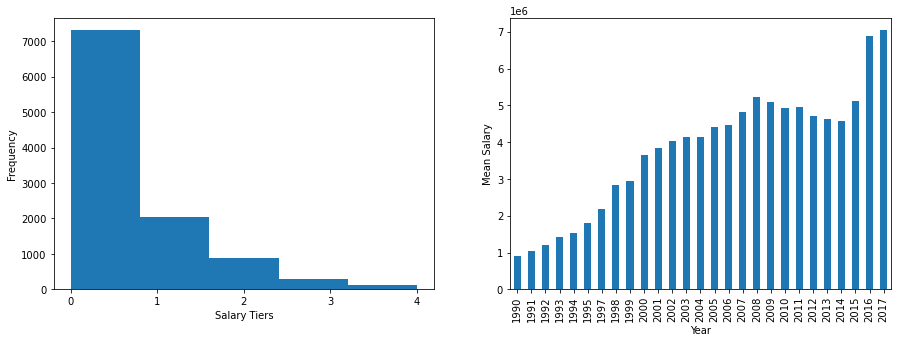

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
merged_data['Salary Tier'].plot.hist(ax=ax1, bins=num_tiers, xticks=[0, 1, 2, 3, 4])
ax1.set_xlabel("Salary Tiers")
merged_data.groupby('Season End')['Salary'].mean().sort_index().plot.bar(ax=ax2)
ax2.set_xlabel("Year")
ax2.set_ylabel("Mean Salary")
plt.show()

In [145]:
# Export data

# Scikit-learn Pipeline

## 80/20 Train-Test Split

In [47]:
merged_data.columns

Index(['Season End', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Salary', 'Salary Tier'],
      dtype='object')

In [60]:
merged_data_final = merged_data.drop('Player', axis=1).drop('Tm', axis=1).drop('Salary', axis=1)
y = merged_data_final.pop('Salary Tier')
X_train, X_test, y_train, y_test = train_test_split(merged_data_final, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.head())

(8515, 48) (8515,)
(2129, 48) (2129,)
      Season End Pos  Age   G  GS    MP   PER    TS%   3PAr    FTr  ...  \
5346        2005  PG   26  80  80  3084  19.2  0.543  0.288  0.327  ...   
4384        2002  PF   26  59   5   650  12.7  0.492  0.014  0.370  ...   
7405        2010  SF   23  67  38  1730  11.5  0.512  0.094  0.274  ...   
6696        2008   C   32  73  73  2222  18.7  0.522  0.001  0.276  ...   
9777        2015  PG   26  67  67  2302  29.1  0.536  0.196  0.445  ...   

        FT%  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
5346  0.775   77  255  332  541  124   30  203  191  1571  
4384  0.648   89   73  162   44   16   13   22  104   167  
7405  0.847   45  153  198   93   55   19   97  101   657  
6696  0.802  263  419  682  104   34  120  135  247  1029  
9777  0.835  124  364  488  574  140   14  293  184  1886  

[5 rows x 48 columns]


## One hot encoding of Position
We see that we don't need to worry about multicollinearity from these values.

In [51]:
print(X_train['Pos'].value_counts())

PF       1807
C        1778
PG       1657
SG       1607
SF       1541
SG-SF      24
PG-SG      19
SF-SG      18
PF-C       15
C-PF       13
SF-PF      12
SG-PG      12
PF-SF       9
SG-PF       3
Name: Pos, dtype: int64


In [110]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(X_train['Pos'].values.reshape(-1, 1)).shape

(8515, 14)

### Categorical Transformation Pipeline
We will use a ColumnTransformer to fit transformations in parallel rather than run `cat_pipe.fit_transform(cat_Xtrain)` and `num_pipe.fit_transform(num_Xtrain)` ourselves sequentially.

In [120]:
# TransformerMixin: Need to implem fit and transform, we get fit_transform which invokes both
# BaseEstimator: We get get_params and set_params
class YearlyScaler(BaseEstimator, TransformerMixin):
    def __init__(self, year_col: str, scaler: Type[Union[BaseEstimator, TransformerMixin]], 
                 return_df: bool = False):
        # FOR SOME FUCKING REASON THESE CAN'T BE MANGLED ARRRRGGHGHHGHGHGHGHGH
        self.scaler = scaler
        self.year_col = year_col
        self.return_df = return_df
    
    def fit(self, X: pd.DataFrame, y=None):
        """Blah
        
        Parameters
        ----------
        X : DataFrame, shape [n_samples, n_features]
            The data used to blah.
        y : Ignored
        
        Returns
        -------
        self: object
            Fitted scaler
        """
        # Omit the groupby column
        #print(self._year_col)
        self._columns = [col for col in X.columns.values if col != self.year_col]
        print(self._columns)
        
        # Split data into categorical and numeric;
        # we only want to scale the numerical data
        #self._dtypes = X.dtypes.values
        #self._kinds = np.array([dt.kind for dt in X.dtypes])
        #self._column_dtypes = {}
        #is_categorical = self._kinds == 'O'  # Mask over _kinds
        #self._column_dtypes['cat'] = self._columns[is_categorical]
        #self._column_dtypes['num'] = self._columns[~is_categorical]
        
        return self
    
    def transform(self, X: pd.DataFrame) -> Union[pd.DataFrame, np.ndarray]:
        """Blah
        
        Parameters
        ----------
        X : DataFrame, shape [n_samples, n_features]
            The data used to scale along the features axis.
            
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Transformed array.
        """
        # Apply the self._scaler transform on all the numerical columns grouped by the Year column
        # Remove the scaled Year column (iloc[:, 1:] says all rows, ignore 0th column, which is Year)
        # Will give us a multi-indexed DF with the years as the 0-level index
        #print(X[[self._year_col] + self._columns])
        X_tr = X[[self.year_col]+self._columns].groupby(self.year_col).apply(
            lambda x, scaler=self.scaler: pd.DataFrame(scaler.fit_transform(x)).iloc[:, 1:])
        # Drop the year index
        X_tr.index = X_tr.index.droplevel(0)
        
        return X_tr if self.return_df else X_tr.to_numpy()

In [16]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
def f(df: pd.DataFrame, scaler: Type[Union[BaseEstimator, TransformerMixin]]) -> pd.DataFrame:
    return pd.DataFrame(scaler.fit_transform(df)).iloc[:, 1:]

In [69]:
a = X_train[['Season End']+['Age', 'MP', 'PTS']].groupby('Season End').apply(
    lambda x, scaler=std_scaler: pd.DataFrame(scaler.fit_transform(x)).iloc[:, 1:])
#a.index = a.index.droplevel(0)
a

1         2         3
Season End                                  
1990       0    0.070492  1.560433  2.026737
           1   -1.110583 -0.443148 -0.654850
           2   -1.110583 -1.318402 -1.087187
           3    0.956299  1.430029  2.570351
           4    2.137374 -1.423389 -1.198464
...                  ...       ...       ...
2017       361  2.291372  0.585530 -0.087307
           362  0.440065 -0.794313 -0.754116
           363 -0.022762  1.790074  2.653553
           364 -1.411242 -0.873197 -0.587939
           365  0.208651 -1.211271 -0.985501

[8515 rows x 3 columns]

In [272]:
b = minmax_scaler.fit_transform(a)
b.shape

(8515, 3)

In [273]:
std_scaler.fit_transform(b)

array([[-1.06778312,  0.13795273, -0.19228128],
       [-0.47487527, -1.54908328, -1.11677818],
       [ 0.11803258, -0.95416968, -0.92938016],
       ...,
       [-0.07021224, -0.23593321, -0.36655774],
       [-0.07021224,  1.6781692 ,  2.42502248],
       [-1.2415415 ,  2.11697046,  2.74394487]])

In [128]:
# Get column types
kinds = np.array([dt.kind for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = kinds != 'O'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]

# Define labeled categorical transformation steps
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')) # Dense matrix for potential time/space complexity

# Put the categorical transformations in a Pipeline to be executed sequentially
cat_steps = [cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

# Define labeled numerical transformation steps
num_scale_step = ('scale', YearlyScaler('Season End', StandardScaler(), return_df=True))

# Would do the following if creating a Pipeline to feed to ColumnTransformer
# Put the numerical transformations in a Pipeline also
num_steps = [num_scale_step]
num_pipe = Pipeline(num_steps)

cat_col_transformers = ('cat', cat_pipe, cat_cols)
num_col_transformers = ('num', num_pipe, num_cols)

by_col_transformers = [cat_col_transformers, num_col_transformers]

# Create ColumnTransformer which will apply transformations in parallel where possible
col_transformer = ColumnTransformer(transformers=by_col_transformers)
# We pass the whole training DataFrame because the transformers know which Pipelines
# to apply to which columns (specified in the 'transformers' list)
X_train_transformed = col_transformer.fit_transform(X_train)

#transform_pipe = Pipeline([num_scale_step, ('ct', col_transformer)])
#X_train_transformed = transform_pipe.fit_transform(X_train)

print(X_train_transformed.shape)
pd.DataFrame(X_train_transformed).iloc[:, 10:30]

['Age', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
(8515, 60)


,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.070492,0.779346,1.297094,1.560433,0.653194,-0.112714,-0.420631,0.165709,0.317561,-0.709747,-0.385605,-0.177595,0.096807,-0.479121,-0.529946,2.038931
1,0.0,0.0,0.0,0.0,-1.110583,0.092779,-0.492979,-0.443148,-1.156995,-1.110949,-0.400826,-0.181342,0.085084,-1.230504,-0.804322,-0.964303,-0.240751,-0.408774,-1.268015,-0.702185
2,0.0,0.0,0.0,0.0,-1.110583,-1.280354,-1.017656,-1.318402,-1.243194,-1.610066,0.203223,-1.605699,-1.484131,-0.848615,-1.199777,0.629284,-0.690829,-0.760510,-0.406935,-0.111791
3,0.0,0.0,0.0,0.0,0.956299,0.726533,1.297094,1.430029,1.472089,0.868884,-0.232484,0.454919,-0.496107,0.227616,0.033112,-0.419659,-0.353271,-0.268080,-0.972787,1.996760
4,0.0,0.0,0.0,0.0,2.137374,-0.540975,-1.202836,-1.423389,-0.467399,0.952070,2.698638,-1.439404,-1.077297,-1.039560,-1.129990,0.790660,-0.015712,-0.690163,0.724770,-1.355836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.0,0.0,0.0,0.0,2.291372,0.756499,-0.305410,0.585530,-0.579425,-0.297801,1.140561,-0.470701,-0.054995,0.828068,0.555710,0.248446,-0.302313,-0.220911,0.947875,-0.556237
8511,0.0,0.0,0.0,0.0,0.440065,-1.002019,0.265625,-0.794313,-1.089344,-1.357457,0.473731,-0.438128,-0.943000,-0.217297,-0.604641,-0.052437,-0.064107,-0.610253,-0.710009,-0.148293
8512,0.0,0.0,0.0,0.0,-0.022762,0.976314,1.871659,1.790074,1.498022,0.449392,0.454262,-0.144965,-0.745666,-0.715090,-0.801682,1.699133,0.054996,-0.610253,-0.629136,1.965600
8513,0.0,0.0,0.0,0.0,-1.411242,-1.045982,-0.519548,-0.873197,0.648157,0.558075,-1.385605,0.349069,1.203013,0.960813,1.190619,-0.621966,-0.302313,0.168431,0.058279,0.500709


In [129]:
from  sklearn.ensemble import RandomForestClassifier
ml_pipe = Pipeline([('transform', col_transformer), ('rfc', RandomForestClassifier())])
ml_pipe.fit(X_train, y_train)

['Age', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


Pipeline(memory=None,
         steps=[('transform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('ohe',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))],
                                                     

In [130]:
ml_pipe.score(X_train, y_train)

0.9956547269524368

In [131]:
ml_pipe.score(X_test, y_test)

0.6712071395021136